### S13 T01: Aprenentage Supervisat

In [31]:
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt

##### Load the database

In [12]:
#Loading the dataset
df=pd.read_csv('delayedflights.csv', index_col=False, warn_bad_lines=True, error_bad_lines=False)
df.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [13]:
#select the relevant attributes for an objective prediction before flying.  
df=df[['Month', 'DayOfWeek', 'DepTime','ArrTime', 'UniqueCarrier', 'CRSElapsedTime', 
       'Origin', 'Dest', 'Distance','ArrDelay']]
df.head(3)

,Month,DayOfWeek,DepTime,ArrTime,UniqueCarrier,CRSElapsedTime,Origin,Dest,Distance,ArrDelay
0,1,4,2003.0,2211.0,WN,150.0,IAD,TPA,810,-14.0
1,1,4,754.0,1002.0,WN,145.0,IAD,TPA,810,2.0
2,1,4,628.0,804.0,WN,90.0,IND,BWI,515,14.0


In [14]:
# Delete both ArrTime and ArrDelay (target column) null values because they are most likely linked to cancellations and diverions
df.dropna(subset=['ArrTime','UniqueCarrier','ArrDelay'], inplace=True)

In [21]:
df.isnull().sum()

Month             0
DayOfWeek         0
DepTime           0
ArrTime           0
UniqueCarrier     0
CRSElapsedTime    0
Origin            0
Dest              0
Distance          0
ArrDelay          0
dtype: int64

In [18]:
df20 = df.sample(frac =.2).reset_index().drop(['index'], axis=1)
df20.head()

,Month,DayOfWeek,DepTime,ArrTime,UniqueCarrier,CRSElapsedTime,Origin,Dest,Distance,ArrDelay
0,3,5,2158.0,2324.0,NW,204.0,MSP,PHX,1276,30.0
1,5,5,2102.0,2247.0,OO,94.0,ORD,LNK,466,33.0
2,4,5,730.0,1025.0,DL,92.0,STL,ATL,483,38.0
3,6,1,2048.0,2252.0,NW,297.0,DTW,LAX,1979,77.0
4,12,7,8.0,149.0,WN,100.0,SLC,PHX,507,144.0


##### Transform the Arrival delays into binomial, 0 - on time, 1 - delayed

In [19]:
# As per airlines industry, a delayed flight is considered if it arrives 15' or later
def delay(z):
    if z >= 15:
        return 1
    else:
        return 0
    
df20["ArrDelay"] = df20["ArrDelay"].apply(delay)

In [20]:
df20.head()

,Month,DayOfWeek,DepTime,ArrTime,UniqueCarrier,CRSElapsedTime,Origin,Dest,Distance,ArrDelay
0,3,5,2158.0,2324.0,NW,204.0,MSP,PHX,1276,1
1,5,5,2102.0,2247.0,OO,94.0,ORD,LNK,466,1
2,4,5,730.0,1025.0,DL,92.0,STL,ATL,483,1
3,6,1,2048.0,2252.0,NW,297.0,DTW,LAX,1979,1
4,12,7,8.0,149.0,WN,100.0,SLC,PHX,507,1


In [22]:
#df20.to_csv('delays20.csv')



##### Cyclical features encoding

In [23]:
#hores de sortida/arribada
df20['DepTime_sin'] = np.sin(df20.DepTime*(2.*np.pi/2400))
df20['DepTime_cos'] = np.cos(df20.DepTime*(2.*np.pi/2400))
df20['ArrTime_sin'] = np.sin(df20.ArrTime*(2.*np.pi/2400))
df20['ArrTime_cos'] = np.cos(df20.ArrTime*(2.*np.pi/2400))

# mesos
df20['Month_sin'] = np.sin((df20.Month-1)*(2.*np.pi/12))
df20['Month_cos'] = np.cos((df20.Month-1)*(2.*np.pi/12))

# dies setmana
df20['DayOfWeek_sin'] = np.sin((df20.DayOfWeek-1)*(2.*np.pi/7))
df20['DayOfWeek_cos'] = np.cos((df20.DayOfWeek-1)*(2.*np.pi/7))

##### Frequency Encoding  Origin and Dest attributes

In [24]:
fe=df20.groupby('Origin').size()/len(df20)
df20.loc[:,'origin_freq']=df20['Origin'].map(fe)

fe1=df20.groupby('Dest').size()/len(df20)
df20.loc[:,'dest_freq']=df20['Dest'].map(fe1)

fe2=df20.groupby('UniqueCarrier').size()/len(df20)
df20.loc[:,'carrier']=df20['UniqueCarrier'].map(fe2)

In [25]:
# delete encoded columns
df20=df20.drop(['Month','DayOfWeek','DepTime','ArrTime','Origin','Dest','UniqueCarrier'], axis=1)

In [26]:
# RobustScaler i QuantileTransformer per els atributs amb molts outliers
from sklearn.preprocessing import RobustScaler,QuantileTransformer

robust=['Distance']
quantile=['CRSElapsedTime']


scaler = QuantileTransformer()
scaler1 = RobustScaler()

df20[quantile] = scaler.fit_transform(df20[quantile])
df20[robust] = scaler1.fit_transform(df20[robust])

In [29]:
df20.head()

,CRSElapsedTime,Distance,ArrDelay,DepTime_sin,DepTime_cos,ArrTime_sin,ArrTime_cos,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,origin_freq,dest_freq,carrier
0,0.853854,1.015152,1,-0.592013,0.805928,-0.197657,0.980271,0.866025,5.000000e-01,-0.433884,-0.900969,0.016926,0.024635,0.041180
1,0.348849,-0.212121,1,-0.703395,0.710799,-0.389928,0.920845,0.866025,-5.000000e-01,-0.433884,-0.900969,0.065680,0.000430,0.068091
2,0.339339,-0.186364,1,0.942641,-0.333807,0.442289,-0.896873,1.000000,6.123234e-17,-0.433884,-0.900969,0.008883,0.055269,0.058829
3,0.957958,2.080303,1,-0.796530,0.604599,-0.377841,0.925871,0.500000,-8.660254e-01,0.000000,1.000000,0.022649,0.031322,0.041180
4,0.389389,-0.150000,1,0.020942,0.999781,0.380263,0.924878,-0.500000,8.660254e-01,-0.781831,0.623490,0.014766,0.024635,0.194760


In [30]:
df20.to_csv('delays20enc.csv')

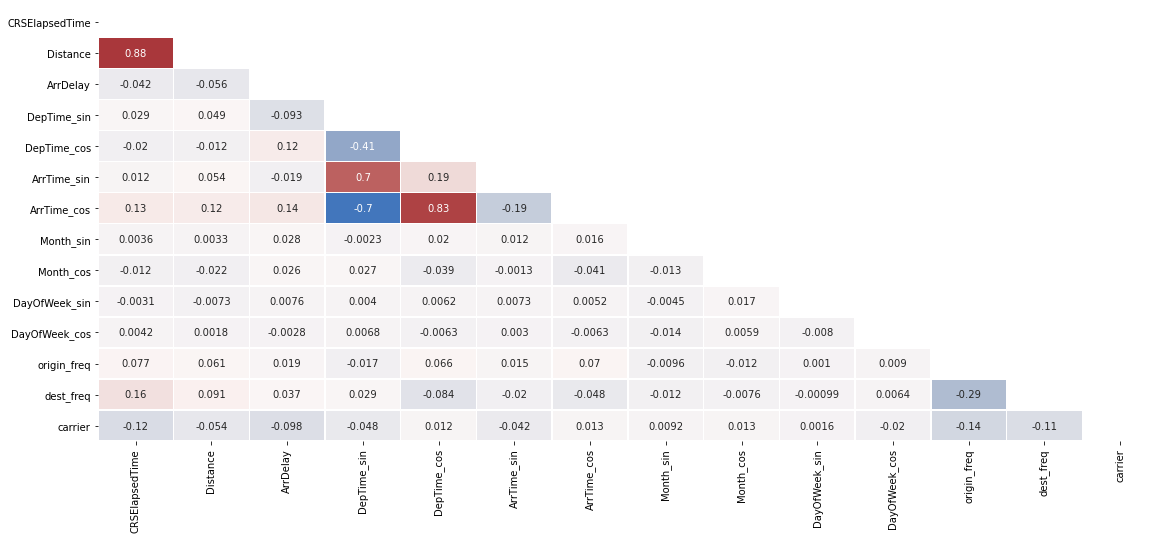

In [32]:
corr = df20.corr()
cmap = sns.light_palette("#0c2a70", as_cmap=True)
mask = np.triu(corr)
plt.figure(figsize=(19,8))
sns.heatmap(corr, cmap='vlag', annot=True, linewidths=0.5, center=0.05, cbar=False, xticklabels=True,
           mask=mask)

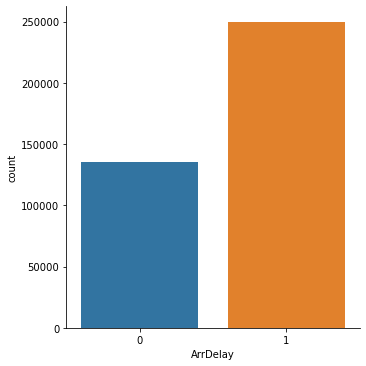

In [36]:
sns.catplot(x="ArrDelay", kind="count", data=df20)